In [ ]:
from DeepLearning_python import *

이번에는 Attention Decoder 클래스를 제작한다. <br />
본래 seq2seq는 인코더를 통해서 의미를 함축한 Context Vector를 생성하고, Decoder가 이를 다시 풀어내는 원리다. <br />
여기서 Attention Decoder의 차이점은 바로, 매 timestep마다 input 문장 전체의 의미를 다시 참고하는 것에 있다. <br />
seq2seq의 가장 큰 문제점은 말 그대로 한 개의 문장을 한 개의 Context Vector로 압축하면서, 문장이 길어질수록 의미의 손실이 커지는 것에 있다. <br />
그러기에, Attention을 도입하면서 이를 보완하고자 했다.

대부분의 코드는 4_Deep Learning_(1)과 유사하지만, <br />
Attention Decoder 클래스를 새롭게 제작하고, train 함수와 evaluate 함수에서 

In [6]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

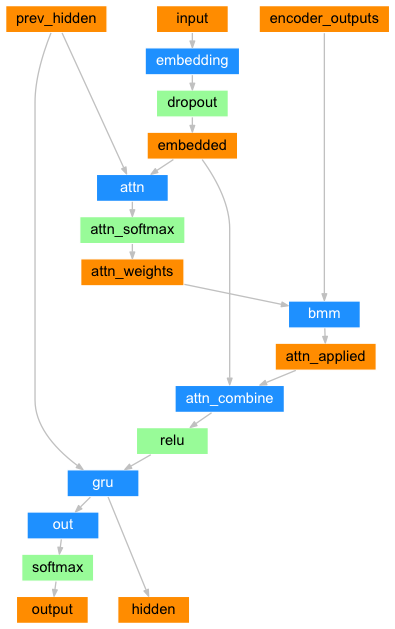

In [28]:
Image("img/attention.png")

위 사진은 Attention Decoder의 대략적인 구조다. <br />
4_Deep learning_(1) simple Decoder에 비해서 확실히 복잡한 구조를 가지고 있다. 

In [9]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  

    else:
        
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [12]:
plot_losses = []
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    
    print_loss_total = 0  
    plot_loss_total = 0 

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) loss: %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

In [10]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [15]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, decoder2, 75000, print_every=5000)

2m 24s (- 33m 46s) (5000 6%) loss: 4.7070
4m 42s (- 30m 34s) (10000 13%) loss: 4.3501
7m 0s (- 28m 1s) (15000 20%) loss: 4.2252
9m 17s (- 25m 33s) (20000 26%) loss: 4.0911
11m 36s (- 23m 13s) (25000 33%) loss: 4.0601
13m 54s (- 20m 51s) (30000 40%) loss: 3.9263
16m 13s (- 18m 32s) (35000 46%) loss: 3.8799
18m 32s (- 16m 13s) (40000 53%) loss: 3.8097
20m 51s (- 13m 54s) (45000 60%) loss: 3.7883
23m 10s (- 11m 35s) (50000 66%) loss: 3.6987
25m 28s (- 9m 15s) (55000 73%) loss: 3.6369
27m 53s (- 6m 58s) (60000 80%) loss: 3.5737
30m 18s (- 4m 39s) (65000 86%) loss: 3.5575
32m 47s (- 2m 20s) (70000 93%) loss: 3.5020
35m 16s (- 0m 0s) (75000 100%) loss: 3.4881


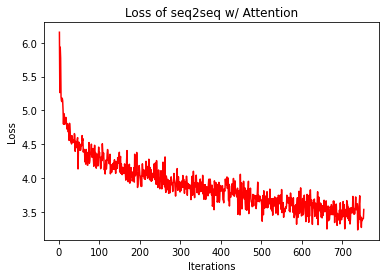

In [18]:
import numpy as np
import matplotlib.pyplot as plt

xdomain = np.arange(753)
xdomain += 1

plt.plot(xdomain, plot_losses,  color='red')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss of seq2seq w/ Attention")

plt.show()

In [26]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

evaluateRandomly(encoder1, decoder2)

def translate(sentence):
    output_words, attentions = evaluate(encoder1, decoder2, sentence)
    output_sentence = ' '.join(output_words)
    print("input(kor): " + sentence)
    print("output(eng): " + output_sentence + "\n")

> 그녀는 매일 오전에 요가를 합니다 .
= She does yoga every morning .
< She is to every every . . <EOS>

> 나는 이 제품이 제거될 거라는 메일을 받았어 .
= I received a mail saying that this product will be removed .
< I received a received this product was in this product . <EOS>

> 우리는 제품이 거래가 시작되고 반품을 진행할 예정입니다 .
= We will return the product after the deal starts .
< We will send the products about the . . <EOS>

> 나는 해운대를 가고 싶어요 .
= I want to go to Haeundae .
< I want to go . <EOS>

> 우리는 화물을 반출해서 재작업 후에 반납할 겁니다 .
= We will take out the shipment and re ship them after re work .
< We are going to the the morning . . <EOS>

> 나는 다음 주에 교육에 참석할 예정입니다 .
= I am planning to attend the training seminar .
< I will going an new car in the next . <EOS>

> 나는 당신을 지켜야 할 의무가 있어요 .
= I have an obligation to protect you .
< I have a you you you you . . <EOS>

> 난 오늘 너와 뜨거운 밤을 보내고 싶어요 .
= I want to spend an amazing night with you .
< I want to have a you you you . <EOS>

> 그는 지난달에 캐나다에 있었습니다 .
= He was in Canada last month .
< He wa

In [43]:
translate("저는 매일 일합니다")
translate("그들은 집에서 쉽니다")
translate("당신은 학교에 가고 있습니다")
translate("우리는 당신을 사랑합니다")
translate("그녀는 그가 보고 싶습니다")

input(kor): 저는 매일 일합니다
output(eng): They every day every day . <EOS>

input(kor): 그들은 집에서 쉽니다
output(eng): They do up at home their home <EOS>

input(kor): 당신은 학교에 가고 있습니다
output(eng): They are going to school . <EOS>

input(kor): 우리는 당신을 사랑합니다
output(eng): We love you for love you . <EOS>

input(kor): 그녀는 그가 보고 싶습니다
output(eng): She would like to see him . <EOS>



4_Deep learning_(1)에서 번역 결과를 보았을 때, 몇가지 단어들만 영어에서 한국어로 바뀌었을 뿐, 성공적인 번역 결과는 얻기 힘들었다. <br /> 하지만, Attention Decoder를 적용했더니, 확실히 몇몇 문장에서는 거의 정확한 영어 문장을 결과값으로 출력하였다. <br />
대신 확실히, 연산이 많아지면서, 모델이 무거워진 것 같다. 학습 시간이 보다 더 늘어나는 것은 어쩔 수 없는 것 같다. <br />
<br />
일단, 이 프로젝트를 이어서 진행할 때, 불용어 처리 및 Okt를 이용한 토큰화를 시도하면 보다 더 높은 정확성을 띠게 될 것 같다. <br />

<h3>모델 저장</h3>

In [44]:
torch.save(encoder1, 'encoder(2).pt')
torch.save(decoder2, 'decoder(2).pt')